In [2]:
dir = 'D:/projects/datascience/bfu-ml-labs/lab_8'

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
import pytorch_lightning as pl

In [4]:
print("CUDA: ", torch.cuda.is_available())

CUDA:  False


# 1. MLP

In [5]:
torch.manual_seed(123)

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = MNIST('.', train=True, download=True, transform=transform)
mnist_val = MNIST('.', train=False, download=True, transform=transform)

In [7]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [8]:
mnist_val

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [9]:
type(mnist_train.data)

torch.Tensor

In [10]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [11]:
len(mnist_train)

60000

In [12]:
len(mnist_train[0])

2

In [13]:
len(mnist_train.data)

60000

In [14]:
len(mnist_train.data[0])

28

In [44]:
train_loader = DataLoader(mnist_train, batch_size=128, num_workers=4, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=128, num_workers=4)

In [45]:
class MetricTracker(pl.Callback):
    def __init__(self):
        super().__init__()

        # Single-float (scalar) tensors, like `tensor(0.5)`.
        self.train_acc: list[torch.Tensor] = []
        self.val_acc: list[torch.Tensor] = []
        self.train_loss: list[torch.Tensor] = []
        self.val_loss: list[torch.Tensor] = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_acc.append(trainer.logged_metrics['acc_epoch'])
        self.train_loss.append(trainer.logged_metrics['loss_epoch'])

    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_acc.append(trainer.logged_metrics['val_acc_epoch'])
        self.val_loss.append(trainer.logged_metrics['val_loss_epoch'])

In [24]:
class TestPredictionTracker(pl.Callback):
    def __init__(self):
        super().__init__()

        # Single-float (scalar) tensors, like `tensor(0.5)`.
        self.preds: list[torch.Tensor] = []
        self.targets: list[torch.Tensor] = []

    def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        y_hat, y = outputs
        self.preds.extend(torch.argmax(y_hat, dim=1).tolist())
        self.targets.extend(y.tolist())

In [46]:
class MLP(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.hidden1 = nn.Linear(28 * 28, 100)
        self.hidden2 = nn.Linear(100, 100)
        self.hidden3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, 10)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.log_softmax(self.output(x), dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.nll_loss(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.log('acc', acc, prog_bar=True, on_step=True, on_epoch=True)
        self.log('loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_acc', acc, prog_bar=True, on_step=True, on_epoch=True)
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat, y

In [47]:
model = MLP()
metrics = MetricTracker()
test_preds = TestPredictionTracker()
trainer = pl.Trainer(max_epochs=5, callbacks=[metrics, test_preds], num_sanity_val_steps=0)
trainer.fit(model, train_loader, val_loader)
print(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | flatten | Flatten | 0     
1 | hidden1 | Linear  | 78.5 K
2 | hidden2 | Linear  | 10.1 K
3 | hidden3 | Linear  | 10.1 K
4 | output  | Linear  | 1.0 K 
------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=784, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
)


In [48]:
print(metrics.train_acc)
print(metrics.val_acc)
print(metrics.train_loss)
print(metrics.val_loss)

[tensor(0.8762), tensor(0.9483), tensor(0.9641), tensor(0.9723), tensor(0.9777)]
[tensor(0.9339), tensor(0.9584), tensor(0.9658), tensor(0.9703), tensor(0.9702)]
[tensor(0.4394), tensor(0.1732), tensor(0.1197), tensor(0.0903), tensor(0.0724)]
[tensor(0.2170), tensor(0.1416), tensor(0.1127), tensor(0.0979), tensor(0.0950)]


In [49]:
from matplotlib import pyplot as plt


def plot_learning_curve(metrics: MetricTracker):
    plt.figure(figsize=(10, 3))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(metrics.train_acc, label='Training Accuracy')
    plt.plot(metrics.val_acc, label='Validation Accuracy')
    plt.legend()
    plt.xticks(range(len(metrics.train_acc)))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(metrics.train_loss, label='Training Loss')
    plt.plot(metrics.val_loss, label='Validation Loss')
    plt.legend()
    plt.xticks(range(len(metrics.train_loss)))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.show()

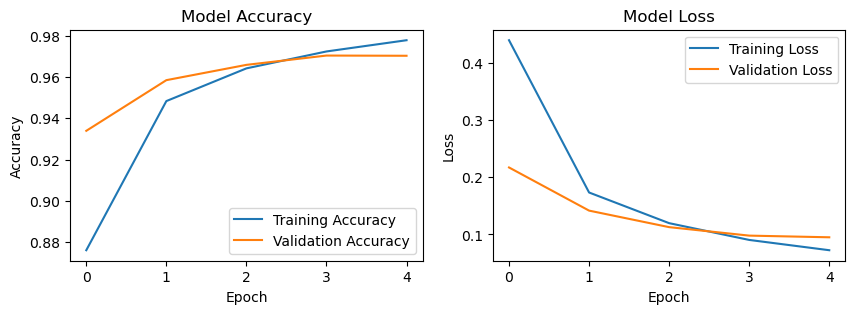

In [50]:
plot_learning_curve(metrics)

In [51]:
trainer.test(model, val_loader)
y_true = test_preds.targets
y_pred = test_preds.preds

Testing: 0it [00:00, ?it/s]

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.91      0.99      0.95      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.94      0.96       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.99      0.93      0.96       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [53]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bars(model_name, y_true, y_pred):
    metric = 'f1-score'

    report = classification_report(y_true, y_pred, output_dict=True)
    keys = range(10)
    values = [report[str(k)][metric] for k in keys]

    plt.figure(figsize=(5, 5))

    plt.bar(keys, values)
    plt.axhline(np.asarray(values).mean(), c='green', linestyle='dashed')  # average
    plt.axhline(1., c='cyan', linestyle='dashed')  # perfect

    plt.xticks(keys)
    plt.yticks(np.arange(0., 1.05, 0.05))
    plt.xlabel('digit')
    plt.ylabel(metric)
    plt.title('Handwritten Digits Recognition: ' + model_name)

    plt.show()

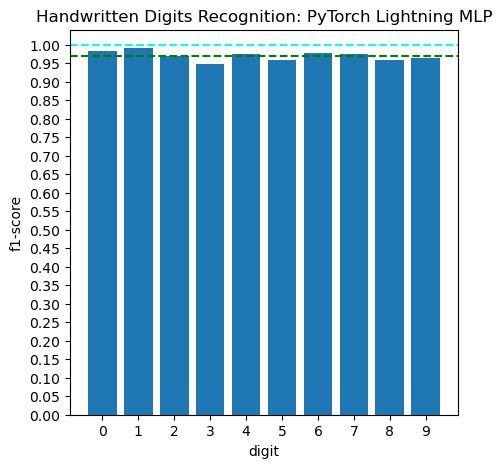

In [54]:
plot_bars('PyTorch Lightning MLP', y_true, y_pred)

In [57]:
from PIL import Image

@torch.no_grad()
def simple_classify_one_mlp(test_pic_file):
    image = Image.open(f'{dir}/{test_pic_file}').convert('L').resize((28, 28))  # grayscale 28x28
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image)

    # For our MLP, we need a 3D array of shape (bach_size, height, width).
    # Here, batch_size = 1 (only 1 image to classify)
    image = image.unsqueeze(0)

    log_probabilities = model(image)
    probabilities = torch.exp(log_probabilities)
    y_pred = torch.argmax(probabilities)
    y_pred_confidence = float(probabilities[0][y_pred])
    print(f'[MLP] Classification: {y_pred}. Confidence: {round(y_pred_confidence * 100., 2)}%')

In [58]:
simple_classify_one_mlp('test_1.png')

[MLP] Classification: 1. Confidence: 99.84%


In [59]:
simple_classify_one_mlp('test_3.png')

[MLP] Classification: 3. Confidence: 99.54%


In [60]:
simple_classify_one_mlp('test_8.png')

[MLP] Classification: 3. Confidence: 67.59%


In [61]:
simple_classify_one_mlp('test_9.png')

[MLP] Classification: 2. Confidence: 25.76%


# 2. CNN

In [62]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # We had pics of size 28. After conv1, they are 28-4. After 1st pooling, they are (28-4)/2.
        # After conv2, they are ((28-4)/2)-4. Finally, after 2nd pooling, they are (((28-4)/2)-4)/2 = 4.
        # And conv2 outputs 64 feature maps for each input sample. Hence the 64 * 4 * 4.
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = self.conv1(x)  # 28x28 images -> 32 x (24x24) feature maps
        x = F.relu(x)  # conv1 activation
        x = F.max_pool2d(x, 2)  # 24x24 feature maps -> 12x12 feature maps

        x = self.conv2(x)  # 32 x (12x12) feature maps -> 64 x (8x8) feature maps
        x = F.relu(x)  # conv2 activation
        x = F.max_pool2d(x, 2)  # 8x8 feature maps -> 4x4 feature maps

        x = x.view(x.size(0), -1)  # flatten: 4x4 feature maps -> 16x1 feature vector
        x = self.fc1(x)  # dense: 16x1 feature vector -> [compute weighted sum and bias] -> 500 scalar outputs
        x = F.relu(x)  # fc1 activation
        x = F.dropout(x, 0.5)  # dropout

        x = self.fc2(x)  # 500 scalars -> [compute weighted sum and biases] -> 10 scalar outputs
        x = F.log_softmax(x, dim=1)  # fc2 activation (output probabilities for each of the 10 classes)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.nll_loss(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.log('acc', acc, prog_bar=True, on_step=True, on_epoch=True)
        self.log('loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_acc', acc, prog_bar=True, on_step=True, on_epoch=True)
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat, y

In [63]:
model = CNN()
metrics = MetricTracker()
test_preds = TestPredictionTracker()
trainer = pl.Trainer(max_epochs=5, callbacks=[metrics, test_preds], num_sanity_val_steps=0)
trainer.fit(model, train_loader, val_loader)
print(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 832   
1 | conv2 | Conv2d | 51.3 K
2 | fc1   | Linear | 512 K 
3 | fc2   | Linear | 5.0 K 
---------------------------------
569 K     Trainable params
0         Non-trainable params
569 K     Total params
2.278     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


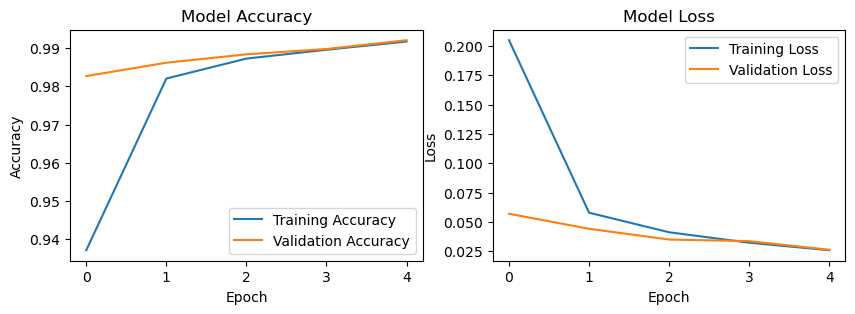

In [64]:
plot_learning_curve(metrics)

In [65]:
trainer.test(model, val_loader)
y_true = test_preds.targets
y_pred = test_preds.preds

Testing: 0it [00:00, ?it/s]

In [66]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



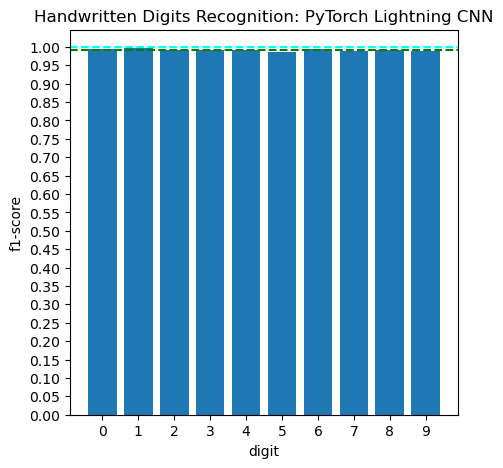

In [68]:
plot_bars('PyTorch Lightning CNN', y_true, y_pred)

In [71]:
from PIL import Image

@torch.no_grad()
def simple_classify_one_cnn(test_pic_file):
    image = Image.open(f'{dir}/{test_pic_file}').convert('L').resize((28, 28))  # grayscale 28x28
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image)

    # For our CNN, we need a 4D array of shape (bach_size, num_channels, height, width).
    # Here, batch_size = 1 (only 1 image to classify), channels = 1 (grayscale -- just the luminosity).
    image = image.unsqueeze(0)

    log_probabilities = model(image)
    probabilities = torch.exp(log_probabilities)
    y_pred = torch.argmax(probabilities)
    y_pred_confidence = float(probabilities[0][y_pred])
    print(f'[CNN] Classification: {y_pred}. Confidence: {round(y_pred_confidence * 100., 2)}%')

In [72]:
simple_classify_one_cnn('test_1.png')

[CNN] Classification: 1. Confidence: 99.97%


In [73]:
simple_classify_one_cnn('test_3.png')

[CNN] Classification: 3. Confidence: 100.0%


In [74]:
simple_classify_one_cnn('test_8.png')

[CNN] Classification: 8. Confidence: 82.12%


In [75]:
simple_classify_one_cnn('test_9.png')

[CNN] Classification: 3. Confidence: 40.56%
